# Weighted K-Means

In this exercise we will simulate finding good locations for production plants of a company in order to minimize its logistical costs. In particular, we would like to place production plants near customers so as to reduce shipping costs and delivery time.

We assume that the probability of someone being a customer is independent of its geographical location and that the overall cost of delivering products to customers is proportional to the squared Euclidean distance to the closest production plant. Under these assumptions, the K-Means algorithm is an appropriate method to find a good set of locations. Indeed, K-Means finds a spatial clustering of potential customers and the centroid of each cluster can be chosen to be the location of the plant.

Because there are potentially millions of customers, and that it is not scalable to model each customer as a data point in the K-Means procedure, we consider instead as many points as there are geographical locations, and assign to each geographical location a weight $w_i$ corresponding to the number of inhabitants at that location. The resulting problem becomes a weighted version of K-Means where we seek to minimize the objective:

$$
J(c_1,\dots,c_K) = \frac{\sum_{i} w_i \min_k ||x_i-c_k||^2}{\sum_{i} w_i},
$$

where $c_k$ is the $k$th centroid, and $w_i$ is the weight of each geographical coordinate $x_i$. In order to minimize this cost function, we iteratively perform the following EM computations:

* **Expectation step:** Compute the set of points associated to each centroid:
$$
\forall~1 \leq k \leq K: \quad \mathcal{C}(k) \leftarrow \Big\{ i ~:~ k = \mathrm{arg}\min_k \| x_i - c_k \|^2 \Big\}
$$


* **Minimization step:** Recompute the centroid as a the (weighted) mean of the associated data points:
$$
\forall~1 \leq k \leq K: \quad c_k \leftarrow \frac{\sum_{i \in \mathcal{C}(k)} w_i \cdot x_i}{\sum_{i \in \mathcal{C}(k)} w_i}
$$


until the objective $J(c_1,\dots,c_K)$ has converged.


## Getting started

In this exercise we will use data from http://sedac.ciesin.columbia.edu/, that we store in the files `data.mat` as part of the zip archive. The data contains for each geographical coordinates (latitude and longitude), the number of inhabitants and the corresponding country. Several variables and methods are provided in the file `utils.py`:


*  **`utils.population`** A 2D array with the number of inhabitants at each latitude/longitude.


*  **`utils.countries`** A 2D array with the country indicator at each latitude/longitude.


* **`utils.nx`** The number of latitudes considered.


* **`utils.ny`** The number of longitudes considered.


*  **`utils.plot(latitudes,longitudes)`** Plot a list of centroids given as geographical coordinates in overlay to the population density map.

The code below plots three factories (white squares) with geographical coordinates (60,80),
(60,90),(60,100) given as input. 

** NOTE: DELETED THE PLOT **

## Initializing Weighted K-Means (20 P)

Because K-means has a non-convex objective, choosing a good initial set of centroids is important. Centroids are drawn from from the following discrete probability distribution:

$$
P(x,y) = \frac1Z \cdot \text{population}(x,y)
$$

where $Z$ is a normalization constant. Furthermore, to avoid identical centroids, we add a small Gaussian noise to the location of centroids, with standard deviation $0.01$.

**Tasks:**

* **Implement the initialization procedure above.**
* **Run the initialization procedure for K=200 clusters.**
* **Visualize the centroids obtained with your initialization procedure using `utils.plot`.**

C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


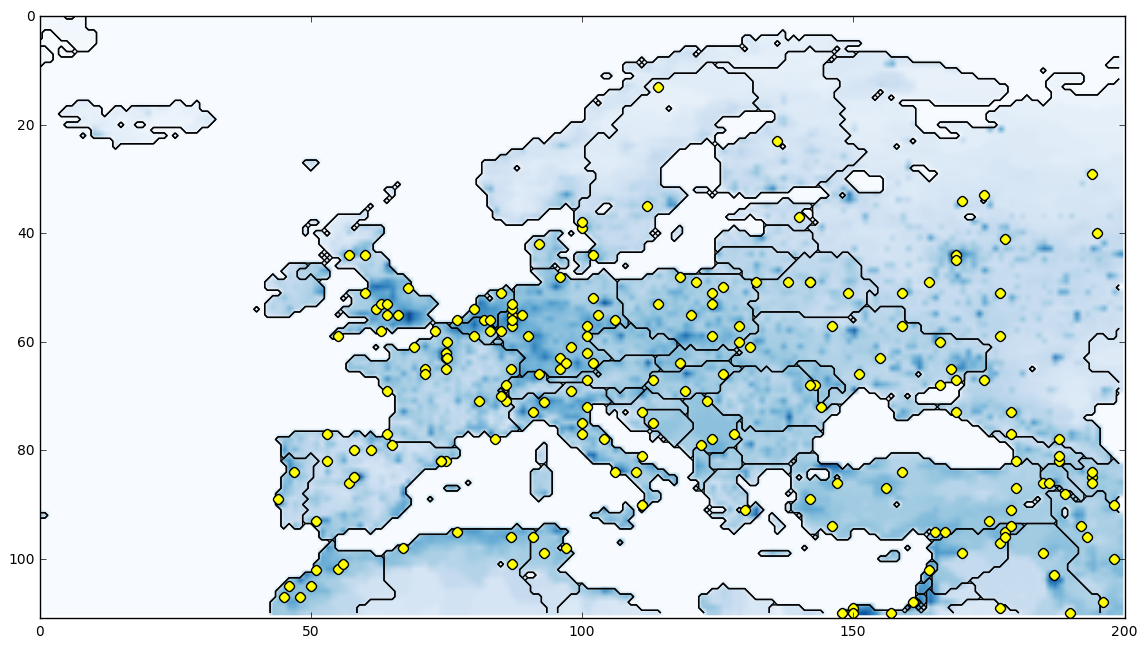

In [6]:
import numpy as np

# find normalising constant Z
flat = utils.population.flatten()
weight = 1/flat.sum() * flat

# make vector of indices
ix = np.arange(len(flat))

# make list of lists containing coordinate pairs
x = list(range(utils.nx))
y = list(range(utils.ny))
coord = np.array(list([i,j] for i in x for j in y))

# draw 200
res = np.random.choice(ix, size = 200, replace = True, p=weight)

# find resulting coordinate pairs [x,y]
coord_res = coord[res]

# draw 2D-array containing Gaussian noise
mu, sigma = 0, 0.01
noise = np.random.normal(mu, sigma, [200,2])

# add noise to the selected coordinates [x+noise_x, y+noise_y]
coord_res = coord_res + noise

# re-arrange for plotting:
xs = list(np.array(coord_res)[:,0])
ys = list(np.array(coord_res)[:,1])

# plot
utils.plot(xs,ys)

## Implementing Weighted K-Means (40 P)

**Tasks:**


* **Implement the weighted K-Means algorithm as described in the introduction.**


* **Run the algorithm with K=200 centroids until convergence (stop if the objective does not improve by more than 0.01). Convergence should occur after less than 50 iterations. If it takes longer, something must be wrong.**


* **Print the value of the objective function at each iteration.**


* **Visualize the centroids at the end of the training procedure using the methods `utils.plot`.**

In [20]:
# define functions 
    # squared Euclidean distance
def sed(x, y):
    diff = np.array(x) - np.array(y)
    return np.dot(diff, diff)

    # find the closest centroid to some point
def close(x, cmeans):
    dist = 10**9
    for i in range(len(cmeans)):
        temp = cmeans[i]
        res = sed(x, temp)
        if res < dist:
            dist = res
            cent = temp
            it = i
    return(dist, cent, it)

In [83]:
# E-step
def estep(coord, flat, cmeans, J_old):
    Dist = []
    Cent = []
    It = []
    for c in coord:
        dist, cent, it = close(c,cmeans)
        Dist.append(dist)
        Cent.append(cent)
        It.append(it)
    # calculate J (flattened weights are in 'flat')
    J = (flat * Dist).sum() / flat.sum()
    print("J = ", J)
    J_old = J
    return(Dist, Cent, It, J_old)

# M-step
def mstep(coord, flat, It):
    coord_upd = np.zeros((200,2))
    for i in range(200):
        indices = [j for j, x in enumerate(It) if x == i]
        if len(indices) == 0:
            print("Mean of cluster with no members:", coord_res[i])
            continue
        myx = np.array(coord[indices])[:,0]
        myy = np.array(coord[indices])[:,1]
        cent_x = (flat[indices] * myx).sum() / (flat[indices]).sum()
        cent_y = ((flat[indices] * myy).sum()) / (flat[indices].sum())
        coord_upd[i] = [cent_x, cent_y]
        # what happens if a cluster has NO members?
    return(coord_upd)

J =  20.1494268886
Oh no, old: [ 110.00501318  151.99051094]
9979.85057311
J =  11.6153791444
8.5340477442
J =  9.92576371205
1.68961543238
J =  9.05431958459
0.871444127461
J =  8.46082171933
0.593497865266
J =  8.20658806593
0.2542336534
J =  8.07857950121
0.128008564719
J =  7.99073086345
0.0878486377583
J =  7.91908161236
0.07164925109
J =  7.85220657879
0.0668750335697
J =  7.79717144418
0.0550351346084
J =  7.75657187625
0.0405995679299
J =  7.71152961232
0.0450422639363
J =  7.67440057628
0.0371290360349
J =  7.64649676707
0.0279038092131
J =  7.63462810575
0.0118686613194
J =  7.62692018594
0.00770791980873


C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


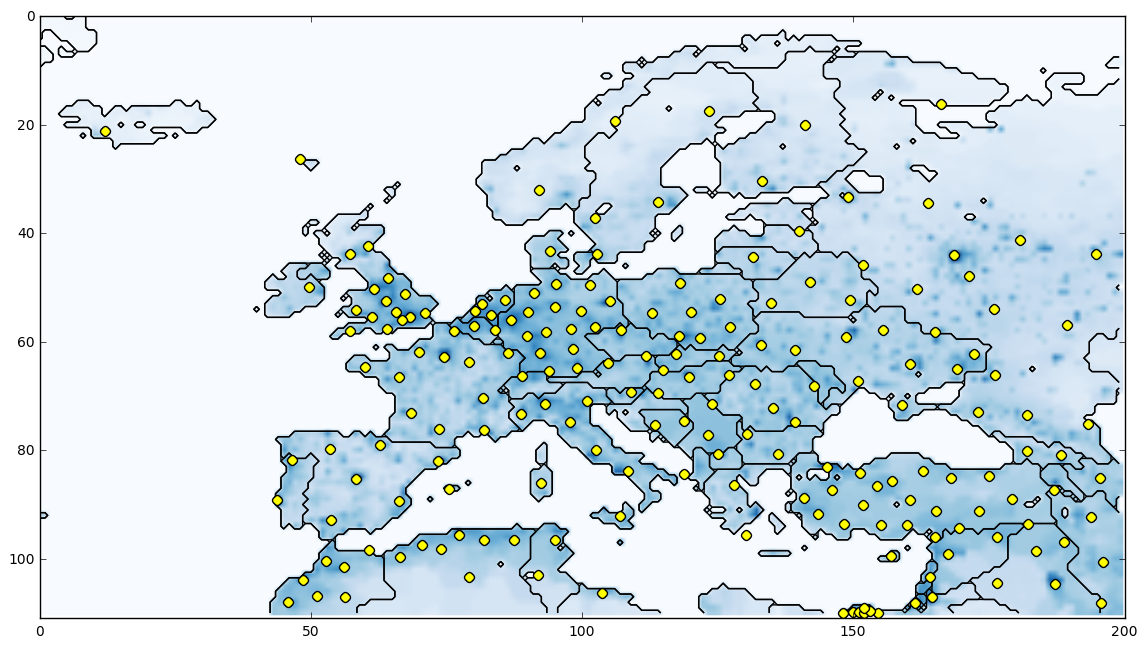

In [84]:
# EM until threshold is reached
    # initialize
go = True
J_old = 10**4
    # run
while go:
    Dist, Cent, It, J = estep(coord, flat, cmeans = coord_res, J_old = J_old)
    coord_res = mstep(coord, flat, It)
    go = J_old-J > 0.01
    J_old = J
print("Converged.")

C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


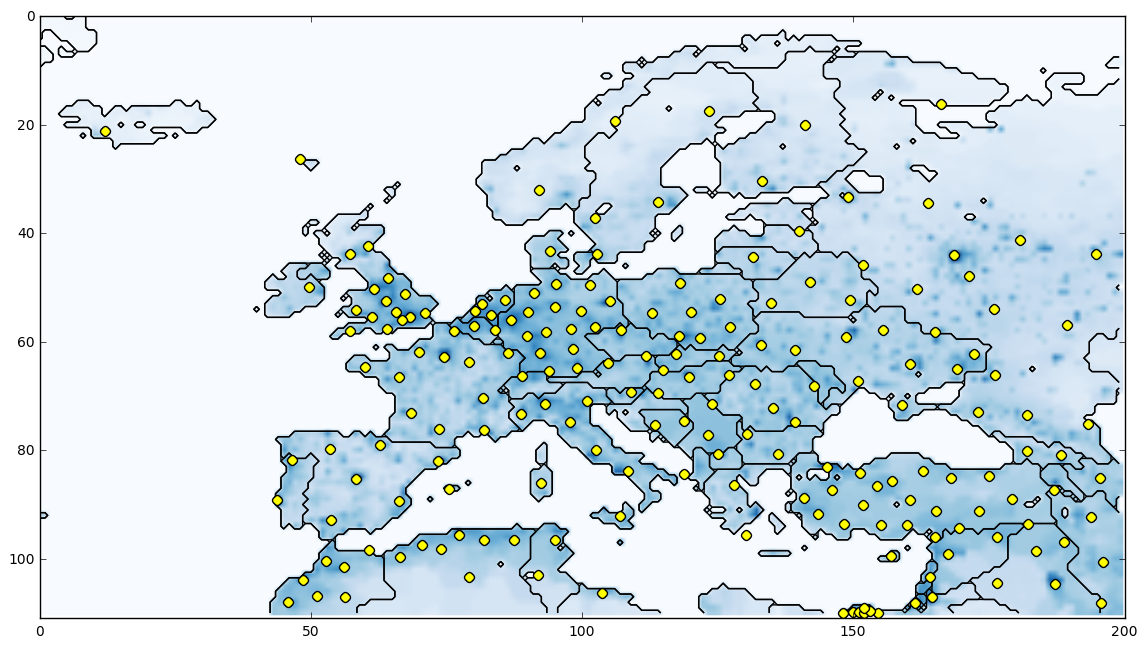

In [85]:
# once we're done, re-arrange and plot
xs = list(np.array(coord_res)[:,0])
ys = list(np.array(coord_res)[:,1])
# plot
utils.plot(xs,ys)

In [24]:
# E-step
Dist = []
Cent = []
It = []
for c in coord:
    dist, cent, it = close(c)
    Dist.append(dist)
    Cent.append(cent)
    It.append(it)
# calculate J (flattened weights are in 'flat')
J = (flat * Dist).sum() / flat.sum()
print(J)

11.4707236202


In [ ]:
# M-step
coord_upd = np.zeros((200,2))

for i in range(200):
    indices = [j for j, x in enumerate(It) if x == i]
    if len(indices) == 0:
        print("Oh no, old:", coord_res[i])
        continue
    myx = np.array(coord[indices])[:,0]
    myy = np.array(coord[indices])[:,1]
    cent_x = (flat[indices] * myx).sum() / (flat[indices]).sum()
    cent_y = ((flat[indices] * myy).sum()) / (flat[indices].sum())
    coord_upd[i] = [cent_x, cent_y]
    # what happens if a cluster has NO members?
    print(coord_res[i],coord_upd[i])

In [163]:
indices = [j for j, x in enumerate(It) if x == 23]
myx = np.array(coord[indices])[:,0]

oo = (np.array(myx) * np.array(flat[indices])).sum() 
tt = np.array(flat[indices]).sum()
resu = oo/tt
print(resu)
print(coord_res[23][0])
resu == coord_res[23][0]

62.1340299002
62.1340299002


True

In [202]:
# E-step
print(coord[14080])
print(coord_res[0])

print(coord[14080] - coord_res[0])



print(sed(coord[14080],coord_res[0]))

[70 80]
[ 72.01097657  91.9917004 ]
[ -2.01097657 -11.9917004 ]
147.84490522


22200

## Focus on German-Speaking Countries (20 P)

Market analysis has shown that people in German-speaking countries, more precisely, Germany (country 111), Austria(country 104), and Switzerland (country 109), are 25 times more likely to be customers than in other countries.

**Tasks:**

* **Describe the necessary changes to the problem setup to take into account this new constraint.**

* **Run k-means on the modified problem.**

* **Visualize the newly obtained centroids using the methods `utils.plot`.**

Multiply the weights for all the coordinates in these countries by 25, and re-estimate (I use the final result from the last exercise to initialize).

In [103]:
ger = [111, 104, 109]
flag = []
for c in ger:
    flag.append([i for i, x in enumerate(utils.countries.flatten()) if x==c])
flag = [item for sublist in flag for item in sublist]

C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


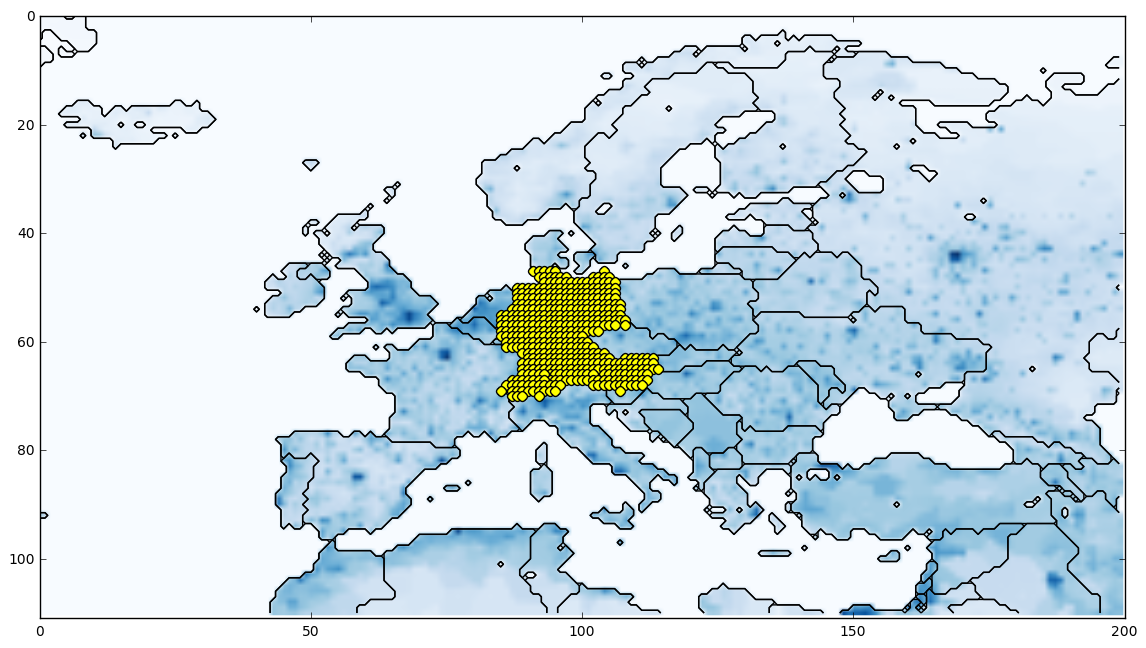

In [106]:
# Let's see if we got this right:
xs = list(np.array(coord[flag])[:,0])
ys = list(np.array(coord[flag])[:,1])
# plot
utils.plot(xs,ys)

In [120]:
w = np.copy(flat)
w[flag] = w[flag] * 25

In [124]:
# EM until threshold is reached
    # initialize
go = True
J_old = 10**4
    # run
while go:
    Dist, Cent, It, J = estep(coord, flat = w, cmeans = coord_res, J_old = J_old)
    coord_res = mstep(coord, flat = w, It = It)
    go = J_old-J > 0.01
    J_old = J
print("Converged.")

J =  4.19997962426
J =  3.89216737588
J =  3.82682701484
J =  3.7936270518
J =  3.75512645679
J =  3.72030367489
J =  3.68688783013
J =  3.66898849131
J =  3.65348092305
J =  3.63395796986
J =  3.62548298755
Converged.


C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\johndoe\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


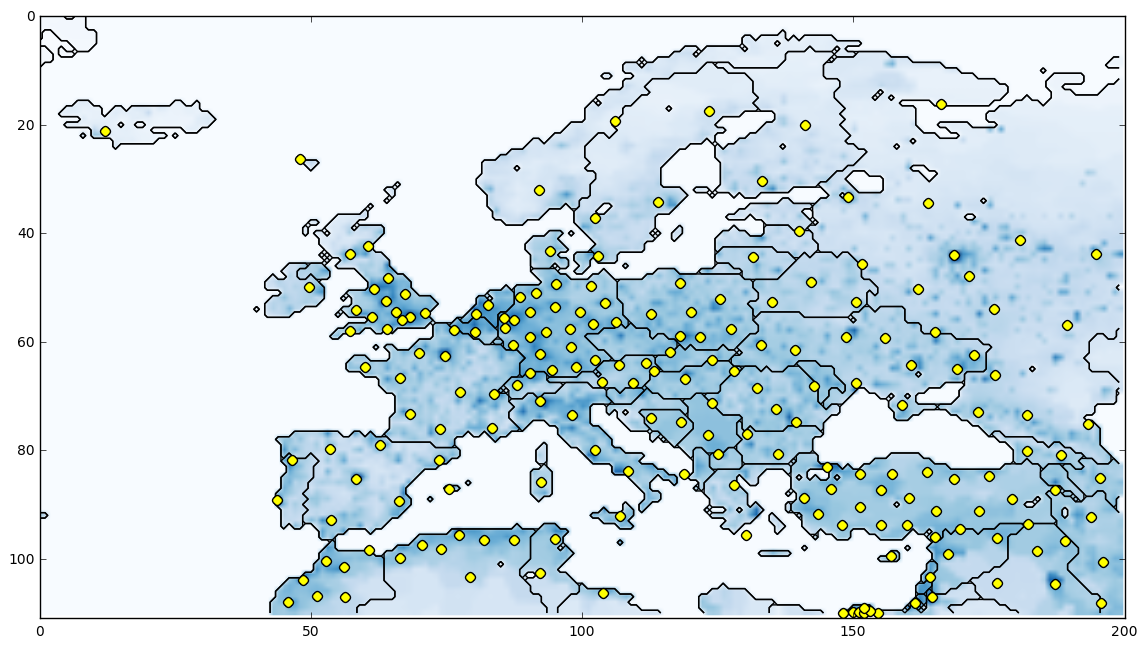

In [125]:
# once we're done, re-arrange and plot
xs = list(np.array(coord_res)[:,0])
ys = list(np.array(coord_res)[:,1])
# plot
utils.plot(xs,ys)

## Shipping Restrictions (20 P)

We now suppose that deliveries across national borders are taxed heavily, and should be avoided as much as possible.

**Tasks:**

* **Describe the necessary changes to the problem setup to take into account this new constraint.**

* **Run k-means on the modified problem.**

* **Visualize the newly obtained centroids using the methods `utils.plot`.**

Adapt the E-step: When looking for the closest cluster centroid, only consider centroids that are in the same country as the coordinate. Determine "nationality" of cluster centroid by nationality of nearest coordinate.

In [132]:
ctr = [54.54,23.18]
ctr_r = [round(i) for i in ctr]

utils.countries.flatten()

array([  68.,   68.,   68., ...,  166.,  166.,  166.], dtype=float32)

111.0

In [ ]:


# M-step
def mstep(coord, flat, It):
    coord_upd = np.zeros((200,2))
    for i in range(200):
        indices = [j for j, x in enumerate(It) if x == i]
        if len(indices) == 0:
            print("Mean of cluster with no members:", coord_res[i])
            continue
        myx = np.array(coord[indices])[:,0]
        myy = np.array(coord[indices])[:,1]
        cent_x = (flat[indices] * myx).sum() / (flat[indices]).sum()
        cent_y = ((flat[indices] * myy).sum()) / (flat[indices].sum())
        coord_upd[i] = [cent_x, cent_y]
        # what happens if a cluster has NO members?
    return(coord_upd)

In [12]:
centroid_ctr = list()
for centroid in coord_res:
    res = findCountry(centroid = centroid, coord = coord, countries_flat = countries_flat)
    centroid_ctr.append(res)

In [22]:
# take a centroid (ctr), and round:
ctr = [60.18,99.54]
ctr_r = [round(i) for i in ctr]

# find the nationality of the corresponding coordinate 
coord_x = list(np.array(coord)[:,0])
coord_y = list(np.array(coord)[:,1])

sol_x = [i for i, x in enumerate(coord_x) if x == ctr_r[0]]
sol_y = [i for i, x in enumerate(coord_y) if x == ctr_r[1]]

sol = list(set(sol_x) & set(sol_y))[0]
coord_x[sol]
coord_y[sol]
utils.countries.flatten()[sol]

111.0

In [18]:
# flatten countries
countries_flat = utils.countries.flatten()

# find the nationality of a centroid
def findCountry(centroid, coord, countries_flat):
    # round the given centroid:
    ctr_r = [round(i) for i in centroid]

    # find the nationality of the corresponding coordinate 
    coord_x = list(np.array(coord)[:,0])
    coord_y = list(np.array(coord)[:,1])

    sol_x = [i for i, x in enumerate(coord_x) if x == ctr_r[0]]
    sol_y = [i for i, x in enumerate(coord_y) if x == ctr_r[1]]

    sol = list(set(sol_x) & set(sol_y))[0]
    return countries_flat[sol]

# find the closest centroid to some point (given same country)
def closeNational(x, cmeans, countries_flat, ctr_x):
    dist = 10**9
    for i in range(len(cmeans)):
        temp = cmeans[i]
        cent_ctr = findCountry(centroid = temp, coord = coord, countries_flat = countries_flat)
        res = sed(x, temp)
        if res < dist and cent_ctr == ctr_x:
            dist = res
            cent = temp
            it = i
    return(dist, cent, it)

# adapted E-step
def estepNational(coord, flat, cmeans, countries_flat, J_old):
    Dist = []
    Cent = []
    It = []
    for i in range(len(coord)):
        x = coord[i]
        ctr_x = countries_flat[i]
        dist, cent, it = closeNational(x, cmeans,countries_flat, ctr_x)
        Dist.append(dist)
        Cent.append(cent)
        It.append(it)
    # calculate J (flattened weights are in 'flat')
    J = (flat * Dist).sum() / flat.sum()
    print("J = ", J)
    J_old = J
    return(Dist, Cent, It, J_old)

In [21]:
# EM until threshold is reached
    # initialize
go = True
J_old = 10**4
    # run
while go:
    Dist, Cent, It, J = estepNational(coord, flat, cmeans = coord_res, countries_flat=countries_flat, J_old = J_old)
    coord_res = mstep(coord, flat, It)
    go = J_old-J > 0.01
    J_old = J
print("Converged.")

UnboundLocalError: local variable 'cent' referenced before assignment